# What is torch.nn really?

## MNIST data setup


In [1]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [2]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

Each image is 28 x 28, and is being stored as a flattened row of length 784 (=28x28). Let’s take a look at one; we need to reshape it to 2d first.

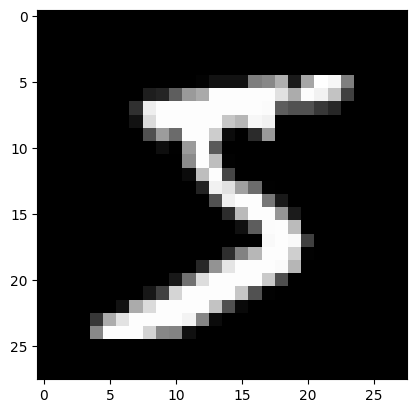

(50000, 784)


In [3]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
# ``pyplot.show()`` only if not on Colab
try:
    import google.colab
except ImportError:
    pyplot.show()
print(x_train.shape)

PyTorch uses torch.tensor, rather than numpy arrays, so we need to convert our data.

In [4]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


## Neural net from scratch (without torch.nn)



In [5]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [6]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

In [7]:
bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.1894, -2.2082, -2.4534, -2.4833, -2.1521, -2.6061, -2.6591, -2.7306,
        -2.2179, -1.7454], grad_fn=<SelectBackward0>) torch.Size([64, 10])


Let’s implement negative log-likelihood to use as the loss function (again, we can just use standard Python):

In [8]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

Let’s check our loss with our random model, so we can see if we improve after a backprop pass later.

In [9]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.2745, grad_fn=<NegBackward0>)


Let’s also implement a function to calculate the accuracy of our model. For each prediction, if the index with the largest value matches the target value, then the prediction was correct.



In [10]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [11]:
print(accuracy(preds, yb))

tensor(0.2031)


We can now run a training loop. For each iteration, we will:

select a mini-batch of data (of size bs)

use the model to make predictions

calculate the loss

loss.backward() updates the gradients of the model, in this case, weights and bias.

In [12]:
from IPython.core.debugger import set_trace

lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        #set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [13]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0803, grad_fn=<NegBackward0>) tensor(1.)


## Using torch.nn.functional
If you’re using negative log likelihood loss and log softmax activation, then Pytorch provides a single function F.cross_entropy that combines the two. So we can even remove the activation function from our model.


In [27]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

In [28]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0803, grad_fn=<NllLossBackward0>) tensor(1.)


## Refactor using nn.Module

In [29]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

Since we’re now using an object instead of just using a function, we first have to instantiate our model:

In [30]:
model = Mnist_Logistic()

In [31]:
print(loss_func(model(xb), yb))

tensor(2.2901, grad_fn=<NllLossBackward0>)


We’ll wrap our little training loop in a fit function so we can run it again later.

In [32]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

Let’s double-check that our loss has gone down:

In [34]:
print(loss_func(model(xb), yb))

tensor(0.0855, grad_fn=<NllLossBackward0>)


## Refactor using nn.Linear

We continue to refactor our code. Instead of manually defining and initializing self.weights and self.bias, and calculating xb  @ self.weights + self.bias, we will instead use the Pytorch class nn.Linear for a linear layer, which does all that for us. Pytorch has many types of predefined layers that can greatly simplify our code, and often makes it faster too.


In [35]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

We instantiate our model and calculate the loss in the same way as before:

In [36]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3527, grad_fn=<NllLossBackward0>)


We are still able to use our same fit method as before.

In [37]:
fit()

print(loss_func(model(xb), yb))

tensor(0.0812, grad_fn=<NllLossBackward0>)


## Refactor using torch.optim

Pytorch also has a package with various optimization algorithms, torch.optim. We can use the step method from our optimizer to take a forward step, instead of manually updating each parameter.

This will let us replace our previous manually coded optimization step:

In [38]:
""" 
instead of :

with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()

we just use:

opt.step()
opt.zero_grad()
"""
from torch import optim

#create a function to create our model and optimizer for future use 

def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.3127, grad_fn=<NllLossBackward0>)
tensor(0.0802, grad_fn=<NllLossBackward0>)


## Refactor using Dataset
 This tutorial walks through a nice example of creating a custom FacialLandmarkDataset class as a subclass of Dataset.

PyTorch’s TensorDataset is a Dataset wrapping tensors. By defining a length and way of indexing, this also gives us a way to iterate, index, and slice along the first dimension of a tensor. This will make it easier to access both the independent and dependent variables in the same line as we train.


In [24]:
from torch.utils.data import TensorDataset

Both x_train and y_train can be combined in a single TensorDataset, which will be easier to iterate over and slice.

In [39]:
train_ds = TensorDataset(x_train, y_train)

In [40]:
'''
Previously, we had to iterate through minibatches of x and y values separately:

xb = x_train[start_i:end_i]
yb = y_train[start_i:end_i]

Now, we can do these two steps together:

xb,yb = train_ds[i*bs : i*bs+bs]

'''

model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))



tensor(0.0813, grad_fn=<NllLossBackward0>)


## refactor using DataLoader

PyTorch’s DataLoader is responsible for managing batches. You can create a DataLoader from any Dataset. DataLoader makes it easier to iterate over batches. Rather than having to use train_ds[i*bs : i*bs+bs], the DataLoader gives us each minibatch automatically.

In [42]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
#dl= dataloader
train_dl = DataLoader(train_ds, batch_size=bs)

In [43]:
'''
Previously, our loop iterated over batches (xb, yb) like this:

for i in range((n-1)//bs + 1):
    xb,yb = train_ds[i*bs : i*bs+bs]
    pred = model(xb)

Now, our loop is much cleaner, as (xb, yb) are loaded automatically from the data loader:

for xb,yb in train_dl:
    pred = model(xb)
'''
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))



tensor(0.0802, grad_fn=<NllLossBackward0>)


Let’s now try to add the basic features necessary to create effective models in practice.

## Add validation

In section 1, we were just trying to get a reasonable training loop set up for use on our training data. In reality, you always should also have a validation set, in order to identify if you are overfitting.

Shuffling the training data is important to prevent correlation between batches and overfitting. On the other hand, the validation loss will be identical whether we shuffle the validation set or not. Since shuffling takes extra time, it makes no sense to shuffle the validation data.

We’ll use a batch size for the validation set that is twice as large as that for the training set. This is because the validation set does not need backpropagation and thus takes less memory (it doesn’t need to store the gradients). We take advantage of this to use a larger batch size and compute the loss more quickly.

In [44]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call model.train() before training, and model.eval() before inference, because these are used by layers such as nn.BatchNorm2d and nn.Dropout to ensure appropriate behavior for these different phases.)

In [45]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.3327)
1 tensor(0.3128)


## Create fit() and get_data()

We’ll now do a little refactoring of our own. Since we go through a similar process twice of calculating the loss for both the training set and the validation set, let’s make that into its own function, loss_batch, which computes the loss for one batch.

We pass an optimizer in for the training set, and use it to perform backprop. For the validation set, we don’t pass an optimizer, so the method doesn’t perform backprop.

In [46]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

fit runs the necessary operations to train our model and compute the training and validation losses for each epoch.

In [47]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

get_data returns dataloaders for the training and validation sets.

In [48]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

Now, our whole process of obtaining the data loaders and fitting the model can be run in 3 lines of code:

In [49]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.29080212817788126
1 0.3040414673924446


## Switch to CNN

We are now going to build our neural network with three convolutional layers. Because none of the functions in the previous section assume anything about the model form, we’ll be able to use them to train a CNN without any modification.

We will use PyTorch’s predefined Conv2d class as our convolutional layer. We define a CNN with 3 convolutional layers. Each convolution is followed by a ReLU. At the end, we perform an average pooling. (Note that view is PyTorch’s version of Numpy’s reshape)

In [50]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1

Momentum is a variation on stochastic gradient descent that takes previous updates into account as well and generally leads to faster training.

In [51]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3787200712442398
1 0.27394107223153114


## using nn.Sequential

torch.nn has another handy class we can use to simplify our code: Sequential . A Sequential object runs each of the modules contained within it, in a sequential manner. This is a simpler way of writing our neural network.

To take advantage of this, we need to be able to easily define a custom layer from a given function. For instance, PyTorch doesn’t have a view layer, and we need to create one for our network. Lambda will create a layer that we can then use when defining a network with Sequential.

In [52]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

The model created with Sequential is simple:

In [53]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3584332577347755
1 0.24180121967792512


## wrapping DataLoader

Our CNN is fairly concise, but it only works with MNIST, because:
It assumes the input is a 28*28 long vector

It assumes that the final CNN grid size is 4*4 (since that’s the average pooling kernel size we used)

Let’s get rid of these two assumptions, so our model works with any 2d single channel image. First, we can remove the initial Lambda layer by moving the data preprocessing into a generator:

In [54]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)


Next, we can replace nn.AvgPool2d with nn.AdaptiveAvgPool2d, which allows us to define the size of the output tensor we want, rather than the input tensor we have. As a result, our model will work with any size input.

In [55]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [56]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3174404988288879
1 0.2653728190362453


## using your accelerator

If you’re lucky enough to have access to an accelerator such as CUDA (you can rent one for about $0.50/hour from most cloud providers) you can use it to speed up your code. First check that your accelerator is working in Pytorch:

In [57]:
# If the current accelerator is available, we will use it. Otherwise, we use the CPU.
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


Let’s update preprocess to move batches to the accelerator:

In [58]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(device), y.to(device)


train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)


Finally, we can move our model to the accelerator.

In [59]:
model.to(device)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

You should find it runs faster now:

In [60]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.20099848241209983
1 0.16803986132442952
